# <center> Honolulu Exploratory Climate Analysis </center>
![BeautifulBeach](https://ohmygosh2009.files.wordpress.com/2011/06/tropical-for-vacation-climate-blog.jpg)

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from pprint import pprint #pretty print

h1_line = '–'*25
degree_sign= u'\N{DEGREE SIGN}' #degree symbol to be used for printing;

In [2]:
# ––––––––––––––––––––––––––––––––––––- * CHECK PLOT DIMENSIONS * ––––––––––––––––––––––––––––––––––––-
plt_dimensions = plt.rcParams["figure.figsize"] 
print(f"Plot Dimensions ⟶ (width = {plt_dimensions[0]}) x (height = {plt_dimensions[1]})")

Plot Dimensions ⟶ (width = 6.0) x (height = 4.0)


In [3]:
# ––––––––––––––––––––––––––––––––––––- * SETTING NEW PLOT DIMENSIONS * ––––––––––––––––––––––––––––––––––––-
plt_dimensions[0] = 16.0                          #set width
plt_dimensions[1] = 9.0                           #set height
plt.rcParams["figure.figsize"] = plt_dimensions #
print(f"Plot Dimensions ⟶ (width = {plt_dimensions[0]}) x (height = {plt_dimensions[1]})")

Plot Dimensions ⟶ (width = 16.0) x (height = 9.0)


## <center> Reflect Tables into SQLAlchemy ORM </center>

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create enginge connection to sqlite DB, automap into local model, reflect tables, & view classes 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base() # reflect an existing database into a new model
Base.prepare(engine, reflect=True) # reflect the tables
Base.classes.keys() # We can view all of the classes that automap found

['measurement', 'station']

In [6]:
# References to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

## <center> Precipication Analysis </center>

In [8]:
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).\
            first()
first_date = session.query(Measurement.date).\
            order_by(Measurement.date.asc()).\
            first()

print(f'The earliest date with available data is {first_date} & the latest date is {last_date}')

The earliest date with available data is ('2010-01-01',) & the latest date is ('2017-08-23',)


### Query & Save the last 12 months of precipitation data and plot the results. 
#### Query of final complete year in data set.

In [9]:
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

### Query to retrieve the data and precipitation scores

In [10]:
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= prev_year).\
          all()
results[0:7]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0)]

### Save Query to Pandas DataFrame & Set Index to 'date'

In [11]:
final_year_df = pd.DataFrame(results, columns=['date', 'precipitation'])
final_year_df.set_index(final_year_df['date'], inplace=True)
final_year_df.head()

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-24,2016-08-24,0.08
2016-08-25,2016-08-25,0.08
2016-08-26,2016-08-26,0.00
2016-08-27,2016-08-27,0.00


### Sort the dataframe by date

In [12]:
final_year_df.drop('date', axis=1, inplace=True)

In [13]:
final_year_df = final_year_df.sort_values('date')
final_year_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


### Use Pandas & Matplotlib to plot the data

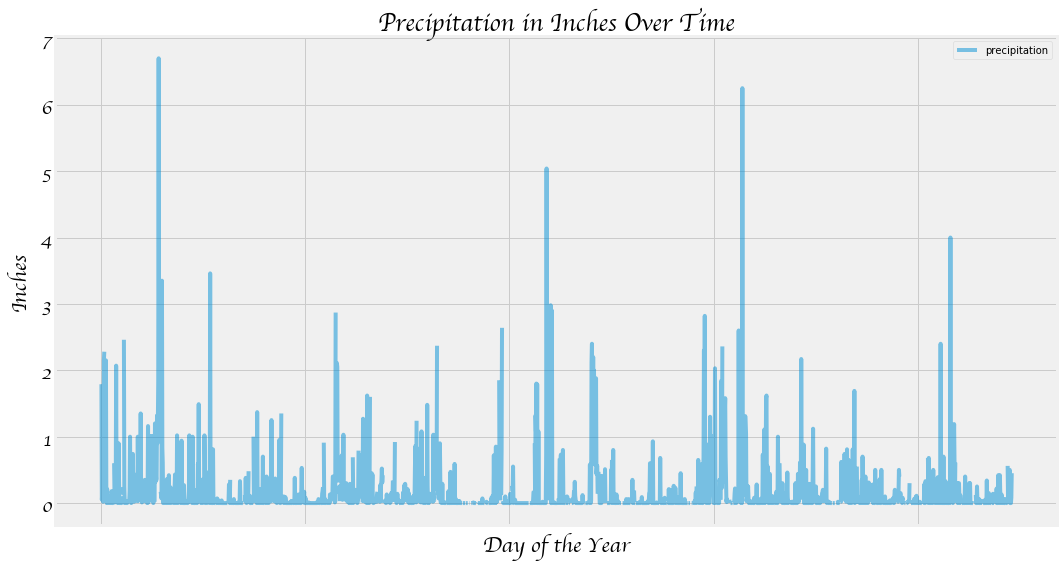

In [14]:
final_year_df.plot(x_compat=True, alpha=0.5)
plt.title("Precipitation in Inches Over Time", fontsize=25, family=['cursive'], weight='bold')
plt.yticks(size=20, family=['cursive'])
plt.ylabel('Inches', size=22, family=['cursive'])
plt.xlabel('Day of the Year', size=22, family=['cursive'])
plt.legend()
plt.xticks(family=['cursive'], size=20)
plt.savefig('Images/precipitation_over_time.png') #save figure
plt.show()

### Use Pandas to calcualte the summary statistics for the precipitation data

In [15]:
final_year_df.describe().T

,count,mean,std,min,25%,50%,75%,max
precipitation,2021.0,0.177279,0.46119,0.0,0.0,0.02,0.13,6.7


<h1 align=center> Station Analysis </h1>

### Query of total available stations

In [16]:

#session.query(Station).count()
number_of_locations = session.query(Station).\
                      group_by(Station.station).\
                      count()
print(f'There are {number_of_locations} different stations')

There are 9 different stations


### Query of Most Active Stations (descending order)

In [17]:
active_stations = session.query(Station.station, func.count(Measurement.station).label('actives')).\
                  filter(Station.station == Measurement.station).\
                  group_by(Station.station).\
                  order_by(func.count(Measurement.station).desc()).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Most Active Station

In [18]:
first_station = active_stations[0].station
print(f'The `id` for the most active station is {first_station}')

The `id` for the most active station is USC00519281


### For Most Active Station, find:
        * lowest temperature, 
        * highest temperature,  
        * average temperature.

In [19]:
most_active_station_sel = [func.min(Measurement.tobs), 
                          func.max(Measurement.tobs),
                          func.avg(Measurement.tobs)]

most_active_station_query = session.query(*most_active_station_sel).\
                            filter(Measurement.station == first_station).\
                            all()
most_active_station_results = list(np.ravel(most_active_station_query)) #ravel will flatten 2x2 to 1 dimension; 
print(f'list(numpy.ravel) will change {most_active_station_query} ⟶ {list(np.ravel(most_active_station_query))}')

list(numpy.ravel) will change [(54.0, 85.0, 71.66378066378067)] ⟶ [54.0, 85.0, 71.66378066378067]


#### breakdown

In [20]:
print(f'Most Active Station: {first_station}')
print(h1_line*2)
print(f'Temperature Statistics:\n\
 Minimum: {most_active_station_query[0][0]}{degree_sign}F,\n\
 Maximum: {round(most_active_station_query[0][2], 1)}{degree_sign}F,\n\
 Average: {most_active_station_query[0][1]}{degree_sign}F.')

print(h1_line*2)

Most Active Station: USC00519281
––––––––––––––––––––––––––––––––––––––––––––––––––
Temperature Statistics:
 Minimum: 54.0°F,
 Maximum: 71.7°F,
 Average: 85.0°F.
––––––––––––––––––––––––––––––––––––––––––––––––––


### Query Final Complete Year of Temperature Observations from Most Active Station

In [21]:
results = session.query(Measurement.station, Measurement.tobs).\
          filter(Measurement.date >= prev_year).\
          filter(Measurement.station == first_station).\
          all()
results[:10]

[('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0)]

### Plot histogram

In [22]:
# create Pandas DataFrame and set the index to the date column
frequency_df = pd.DataFrame(results, columns=['Station', 'Total Observations'])
#frequency_df.head()

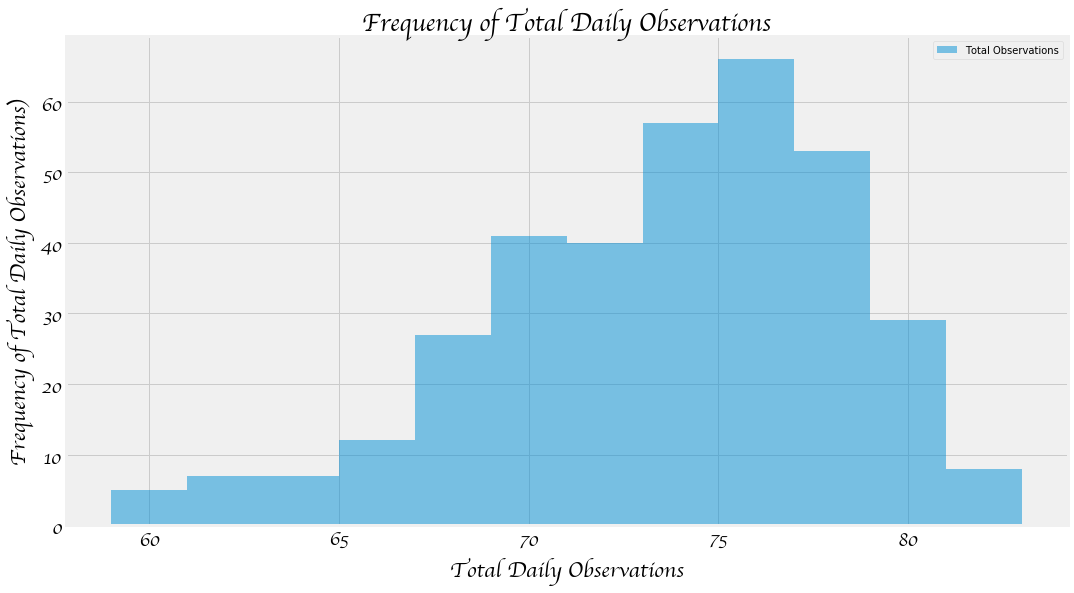

In [23]:
frequency_df.plot.hist(bins=12, alpha=0.5)
plt.title('Frequency of Total Daily Observations', fontsize=25, family=['cursive'], weight='bold')
plt.yticks(size=20, family=['cursive'])
plt.ylabel('Frequency of Total Daily Observations)', size=22, family=['cursive'])
plt.xlabel('Total Daily Observations', size=22, family=['cursive'])
plt.legend()
plt.xticks(family=['cursive'], size=20)
plt.savefig('Images/frequency_of_tobs.png') #save figure
plt.show()

## <center> Temperature Analysis </center>

In [24]:
# The `calc_temps` functions accepts start & end dates in the format '%Y-%m-%d' & returns statistics on date range
def calc_temps(start_date, end_date):
    """
    Arguments:    start_date (string): A date string in the format %Y-%m-%d
                  end_date (string): A date string in the format %Y-%m-%d
    Returns:      TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs)).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).\
                         all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Given Input, Determine (using `calc_temps` ) the Following Expected Temperatures During Trip Duration:
 - Minimum,
 - Average, 
 - Maximum.

In [25]:
# –––––––––––––––––––––––––––––––––––––– User Input –––––––––––––––––––––––––––––––––––––– #

print("Let's determine the temperatures that can be expected during the trip to Hawaii\n\n")
print('–'*30)
month_string = input("What Month? " )
day_string = input("What day? " )
year = int(input("What year? "))
duration = int(input("How many days will you stay? "))
print('–'*30)

month = int(month_string)
day = int(day_string)

# –––––––––––––––––––––––––––––––––––––– Calculations –––––––––––––––––––––––––––––––––––––– #

trip_start_date = str(year) + '–' + str(month) + '-' + str(day) 
pretty_trip_start_date = month_string + '-' + day_string + '-' + str(year)

previous_year_trip_start = dt.date(year, month, day) - dt.timedelta(days=365) #previous year initial date
previous_year_trip_start_string = previous_year_trip_start.strftime('%Y-%m-%d') #needed for 'calc' function

trip_end_date = dt.date(year, month, day) + dt.timedelta(days=duration) # start date + duration
trip_end_date_string = trip_end_date.strftime('%m-%d-%Y') #for printing

previous_year_trip_end = trip_end_date - dt.timedelta(days=365) #previous year final date
previous_year_trip_end_string = previous_year_trip_end.strftime('%Y-%m-%d') #needed for 'calc' function;

expected_temps = calc_temps(previous_year_trip_start_string, previous_year_trip_end_string)

# –––––––––––––––––––––––––––––––––––––– Printing Results –––––––––––––––––––––––––––––––––––––– #

min_expected_temp = expected_temps[0][0]
avg_expected_temp = round(expected_temps[0][1], 1)
max_expected_temp = expected_temps[0][2]

print(f'Expected Trip Duration: {pretty_trip_start_date} through {trip_end_date_string}')
print('–'*30)
print(f'Expected Temperatures:\n\
 Minimum: {min_expected_temp}{degree_sign}F,\n\
 Maximum: {max_expected_temp}{degree_sign}F,\n\
 Average: {avg_expected_temp}{degree_sign}F.')
print('–'*30)

Let's determine the temperatures that can be expected during the trip to Hawaii


––––––––––––––––––––––––––––––
What Month? 02
What day? 15
What year? 2018
How many days will you stay? 12
––––––––––––––––––––––––––––––
Expected Trip Duration: 02-15-2018 through 02-27-2018
––––––––––––––––––––––––––––––
Expected Temperatures:
 Minimum: 61.0°F,
 Maximum: 77.0°F,
 Average: 70.3°F.
––––––––––––––––––––––––––––––


### Plot Temperature Results

In [26]:
trip_temps_df = pd.DataFrame.from_records(expected_temps).rename(columns={0:'Minimum', 1:'Average', 2:'Maximum'})
trip_temps_df

,Minimum,Average,Maximum
0,61.0,70.303797,77.0


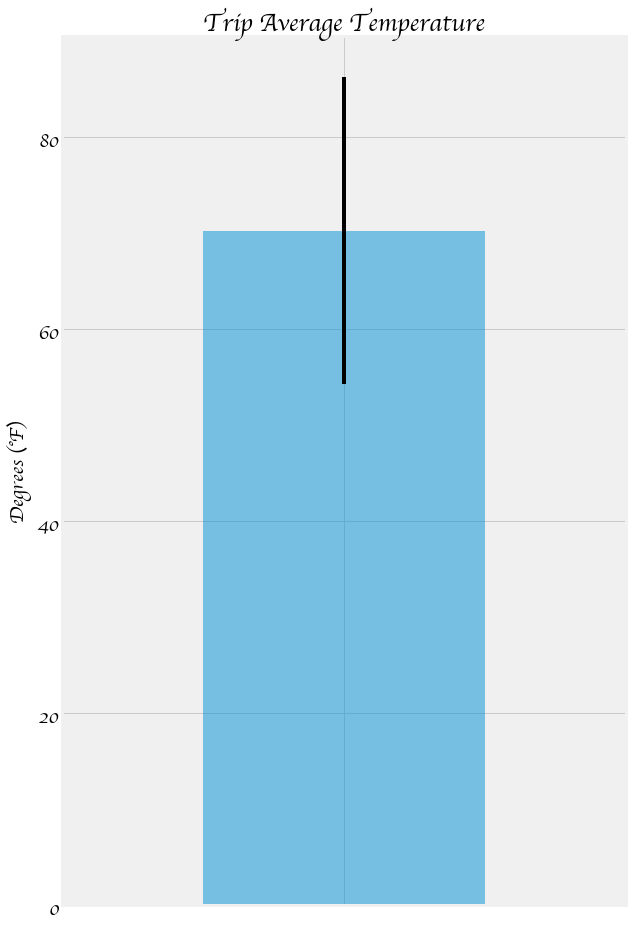

In [27]:
mean = trip_temps_df.Average
y_error_bar = trip_temps_df.Maximum - trip_temps_df.Minimum


temp_avgs_bar = mean.plot.bar(yerr=y_error_bar, 
                              alpha=0.5, 
                              figsize=(9,16))

plt.title('Trip Average Temperature', size=25, family=['cursive'], weight='bold')
plt.xlabel("")
plt.ylabel(f"Degrees ({degree_sign}F)", size=20, family=['cursive'])
plt.yticks(fontsize=20, family=['cursive'])
plt.xticks(color='white', size=1)
plt.tight_layout
plt.savefig('Images/trip_avg_temp.png') #save figure
plt.show()

### Calculate the rainfall per weather station using the previous year's matching dates.

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_query = [Station.name, 
                 Station.station, 
                 Station.elevation, 
                 Station.longitude, 
                 Station.latitude, 
                 func.sum(Measurement.prcp).label('total_rainfall')]
#round(day_normals_result[0][1], 1)
station_results = session.query(*station_query).\
                  filter(Measurement.station == Station.station).\
                  filter(Measurement.date >= previous_year_trip_start).\
                  filter(Measurement.date <= previous_year_trip_end).\
                  group_by(Station.name).\
                  order_by(func.sum(Measurement.prcp).desc()).\
                  all()
                  #order_by('total_rainfall').\ #label not working for descending values
                  
#pprint(station_results[:])
columns = ['Name','Station_ID','Elevation','Longitude','Latitude','Total Rainfall']
total_rainfall_df = pd.DataFrame(np.array(station_results), columns=columns)

total_rainfall_df['Longitude'][0] = '-157.8489'
total_rainfall_df['Total Rainfall'][2] = '0.86'
total_rainfall_df['Total Rainfall'][4] = '0.79'

total_rainfall_df

,Name,Station_ID,Elevation,Longitude,Latitude,Total Rainfall
0,"WAIHEE 837.5, HI US",USC00519281,32.9,-157.8489,21.45167,1.02
1,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,19.5,-157.71139,21.33556,0.87
2,"KANEOHE 838.1, HI US",USC00513117,14.6,-157.8015,21.4234,0.86
3,"MANOA LYON ARBO 785.2, HI US",USC00516128,152.4,-157.8025,21.3331,0.81
4,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,7.0,-157.8374,21.5213,0.79
5,"WAIKIKI 717.2, HI US",USC00519397,3.0,-157.8168,21.2716,0.23
6,"PEARL CITY, HI US",USC00517948,11.9,-157.9751,21.3934,0.17


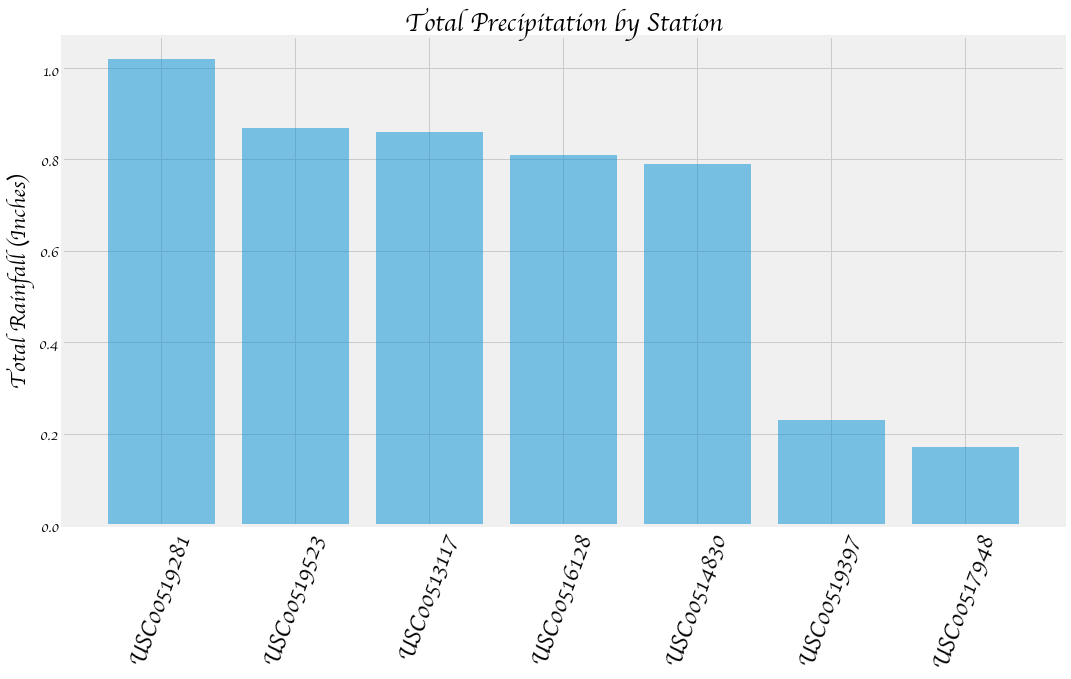

In [29]:
# mean = trip_temps_df.Average
# y_error_bar = trip_temps_df.Maximum - trip_temps_df.Minimum


# temp_avgs_bar = mean.plot.bar(yerr=y_error_bar, 
#                               alpha=0.5, 
#                               figsize=(9,16))

# plt.xlabel("")
# plt.ylabel(f"Degrees ({degree_sign}F)", fontsize=15, family=['cursive'])
# plt.yticks(fontsize='large')

# plt.show()    
# ––––––––––––––––––––––––––––––––––––- * SETTING NEW PLOT DIMENSIONS * ––––––––––––––––––––––––––––––––––––-
plt_dimensions[0] = 16.0                          #set width
plt_dimensions[1] = 9.0                           #set height
plt.rcParams["figure.figsize"] = plt_dimensions #

total_rainfall_series = total_rainfall_df['Total Rainfall']
station_id = total_rainfall_df['Station_ID']
plt.bar(station_id, [float(x) for x in total_rainfall_series], alpha=0.5)
plt.title('Total Precipitation by Station', fontsize=25, family=['cursive'], weight='bold')
plt.yticks(fontsize='x-large', family=['cursive'])
plt.ylabel('Total Rainfall (Inches)', size=22, family=['cursive'])
plt.xticks(family=['cursive'], rotation=70, size=23)
plt.savefig('Images/total_precipitation_by_station.png') #save figure
plt.show()

### Calculate the daily normals for the trip duration

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """
    Args:    date (str): A date string in the format '%m-%d'
    Returns: A list of tuples containing the daily normals, tmin, tavg, and tmax"""
    
    day_sel = [func.min(Measurement.tobs), 
               func.avg(Measurement.tobs), 
               func.max(Measurement.tobs)]
    return session.query(*day_sel).\
                   filter(func.strftime("%m-%d", Measurement.date) == date).\
                   all()
#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––    

print("Let's determine the temperatures that can be expected during a specific day\n\n")
print('–'*30)
month = input("What month? " )
day = input("What day? " )
print('–'*30)

# month = '02'
# day = '15'

day_normals_result = daily_normals(month+str('-')+day)

day_normals_min = day_normals_result[0][0]
day_normals_avg = round(day_normals_result[0][1], 1)
day_normals_max = day_normals_result[0][2]

print(f'On {month}-{day}, you can expect:')
print('–'*30)
print(f'Expected Temperatures:\n\
 Minimum: {day_normals_min}{degree_sign}F,\n\
 Maximum: {day_normals_max}{degree_sign}F,\n\
 Average: {day_normals_avg}{degree_sign}F.')
print('–'*30)

Let's determine the temperatures that can be expected during a specific day


––––––––––––––––––––––––––––––
What month? 02
What day? 15
––––––––––––––––––––––––––––––
On 02-15, you can expect:
––––––––––––––––––––––––––––––
Expected Temperatures:
 Minimum: 56.0°F,
 Maximum: 79.0°F,
 Average: 70.3°F.
––––––––––––––––––––––––––––––


In [31]:
# –––––––––––––––––––––––––––––––––––––– User Input –––––––––––––––––––––––––––––––––––––– #

print("Let's determine the average daily normals that can be expected during the trip to Hawaii\n\n")
print('–'*30)
month_string = input("What Month? " )
day_string = input("What day? " )
year = 2018
duration = int(input("How many days will you stay? "))
print('–'*30)

month = int(month_string)
day = int(day_string)
last_day = dt.date(year, month, day) + dt.timedelta(days=duration)
first_day = dt.date(year, month, day)
# first_day, last_day

Let's determine the average daily normals that can be expected during the trip to Hawaii


––––––––––––––––––––––––––––––
What Month? 02
What day? 15
How many days will you stay? 12
––––––––––––––––––––––––––––––


In [32]:
# given day of arrival & duration, compile list of trip dates (datetime dates) 
trip_dates = []
date = first_day
while date <= last_day:
        trip_dates.append(date)
        date+=dt.timedelta(days=1)
trip_dates[3]

datetime.date(2018, 2, 18)

In [33]:
#convert each of the datetimes to a string format
i=0
while i < len(trip_dates):
    trip_dates[i] = trip_dates[i].strftime('%m-%d')
    i+=1
trip_dates[3]

'02-18'

In [34]:
# min = daily_normals('02-27')[0][0]
# avg = daily_normals('02-27')[0][1]
# max = daily_normals('02-27')[0][2]

In [35]:
# Create 3 lists: 1 for min, 1 for max, 1 for avg; 

normals_min = []
normals_avg = []
normals_max = []

for date in trip_dates:
       normals_min.append(daily_normals(date)[0][0])
       normals_avg.append(round(daily_normals(date)[0][1], 0))
       normals_max.append(daily_normals(date)[0][2])

normals_min[3], normals_avg[3], normals_max[3]

(63.0, 71.0, 77.0)

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
print('The Expected Daily Normals:')

daily_normals_df=pd.DataFrame(data= [trip_dates, normals_min, normals_avg, normals_max]).T
#daily_normals_df(columns=('trip_dates', 'min', 'avg', 'max'))
daily_normals_df.columns=['Dates', 'Minimum', 'Average', 'Maximum']
daily_normals_df.set_index('Dates', inplace=True)
daily_normals_df

The Expected Daily Normals:


,Minimum,Average,Maximum
Dates,,,
02-15,56,70,79
02-16,59,70,76
02-17,62,70,77
02-18,63,71,77
02-19,60,69,77
02-20,63,70,76
02-21,63,70,76
02-22,60,70,83
02-23,62,70,81


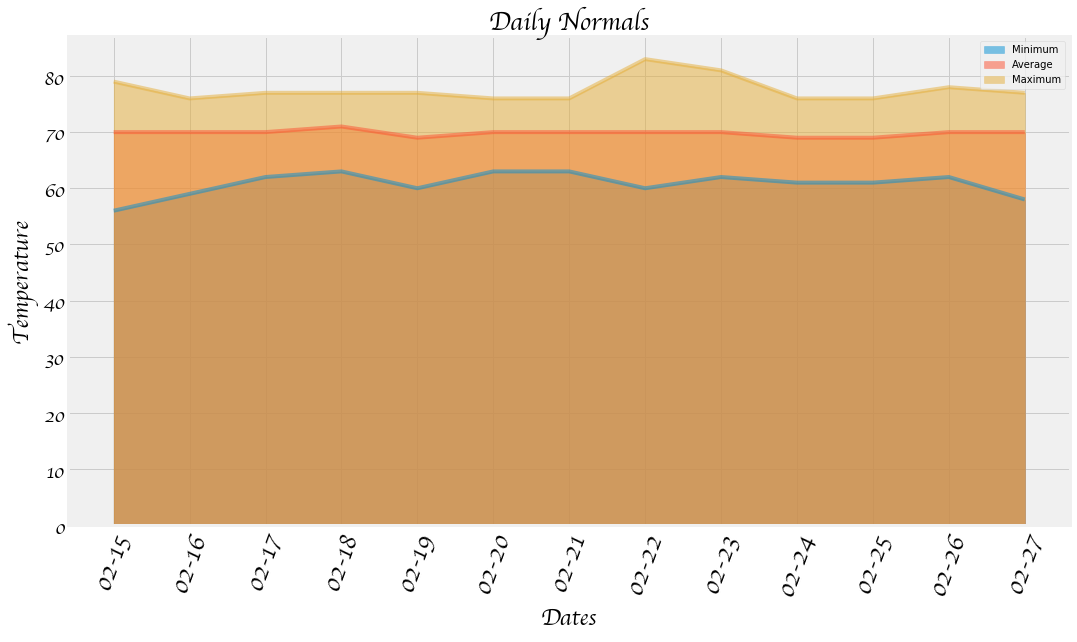

In [37]:
daily_normals_df = daily_normals_df.reset_index()
daily_normals_df.rename(columns={'index':'Dates'})
ax = daily_normals_df.plot(kind='area', stacked=False, xticks=daily_normals_df.index)
ax.set_xticklabels(daily_normals_df['Dates'])
plt.title('Daily Normals', fontsize=25, family=['cursive'], weight='bold')
plt.yticks(fontsize='20', family=['cursive'])
plt.xticks(fontsize='25', family=['cursive'], rotation=70)
plt.ylabel('Temperature', size=23, family=['cursive'])
plt.xlabel('Dates', size=23, family=['cursive'])
plt.savefig('Images/daily_normals.png') #save figure
plt.show()

## Step 2 - Climate App - completed in 'climate_app.py'

Design a Flask API based on the queries that you have just developed.

### Routes

* `/`

  * Home page.

  * List all routes that are available.

* `/api/v1.0/precipitation`

  * Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`
  * query for the dates and temperature observations from a year from the last data point.
  * Return a JSON list of Temperature Observations (tobs) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the analysis queries.

* Use Flask `jsonify` to convert your API data into a valid JSON response object.